# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

In [36]:
import pandas as pd
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


 1. Cleaning Data
 2. Exploratory data analysis
 3. Building recommendation system
 4. Results

In [37]:
## Importing 

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

The most important question in the case provided is how to define "similar buying habits" to customers from Saint Petersburg. Logically, It could be just recent stats (since the decision of recent promotion experience), or it could be just regions with high wine sales (since the successful promotion was related to wine). But the chain of stores sells a variety of alcoholic drinks, and more likely, the marketing team is planning to promote all the production. So the marketing team needs to know in which regions the customers have the same alcohol consumption patterns.

Also, we are looking for similarities in buying habits and not doing other work for the marketing team. We will not consider some critical factors to a company's marketing and financial success but are beyond the scope of our case. It means some assumptions:

- the similarity is much more important than sales per capita. Generally, the finance effect from promotion in regions with higher sales per capita may be better even if promotion works relatively worse;
- marketing costs per capita are the same in all the regions. Population density and size of regions in Russia are very different;
- the only essential data described regions is data provided. We do not care about logistic problems, number of stores, competitors, government regulations. We can take this data into account just for regions with missing data;
- the similarity is a long-term feature. The similarity is not only about sales of alcohol last years, but also changing customer preferences during all the period. Also, for similarity, all drinks matter equally, not counting their volume and alcohol strength.


1. Cleaning data

First of all, we need to explore DataFrame and check for missing values. Then we need to decide how to fix them, if any.

In [39]:
## Examining a dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


In [40]:
df.groupby('region').size().sort_values()

region
Altai Krai                          19
Ryazan Oblast                       19
Rostov Oblast                       19
Republic of Tatarstan               19
Republic of North Ossetia-Alania    19
                                    ..
Kostroma Oblast                     19
Komi Republic                       19
Kirov Oblast                        19
Lipetsk Oblast                      19
Zabaykalsky Krai                    19
Length: 85, dtype: int64

In [41]:
df.groupby('year').size().sort_values()

year
1998    85
2014    85
2013    85
2012    85
2011    85
2010    85
2009    85
2008    85
2015    85
2007    85
2005    85
2004    85
2003    85
2002    85
2001    85
2000    85
1999    85
2006    85
2016    85
dtype: int64

In [42]:
dfnull = df[df.isnull().any(1)]
dfnull['region'].unique()

array(['Republic of Ingushetia', 'Republic of Crimea', 'Sevastopol',
       'Chechen Republic'], dtype=object)

As we can see, each region and each year has the same number of elements, but some data is missing. Missing data is related to four regions; let's explore in more detail and make a decision about it.

In [43]:
## data for Republic of Ingushetia
df[df['region'] == 'Republic of Ingushetia']

,year,region,wine,beer,vodka,champagne,brandy
17,1998,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
102,1999,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
187,2000,Republic of Ingushetia,NaN,NaN,NaN,NaN,NaN
272,2001,Republic of Ingushetia,9.9,9.5,4.00,1.3,1.5
357,2002,Republic of Ingushetia,7.5,8.7,4.30,0.8,0.8
442,2003,Republic of Ingushetia,6.0,8.9,4.60,0.8,0.5
527,2004,Republic of Ingushetia,6.4,7.4,3.60,0.8,0.8
612,2005,Republic of Ingushetia,0.2,0.8,0.80,0.1,NaN
697,2006,Republic of Ingushetia,0.3,0.9,1.00,0.1,NaN
782,2007,Republic of Ingushetia,0.3,1.0,1.00,0.1,NaN


In [44]:
## data for Chechen Republic
df[df['region'] == 'Chechen Republic']

,year,region,wine,beer,vodka,champagne,brandy
79,1998,Chechen Republic,NaN,NaN,NaN,NaN,NaN
164,1999,Chechen Republic,NaN,NaN,NaN,NaN,NaN
249,2000,Chechen Republic,NaN,NaN,NaN,NaN,NaN
334,2001,Chechen Republic,NaN,NaN,NaN,NaN,NaN
419,2002,Chechen Republic,NaN,NaN,NaN,NaN,NaN
504,2003,Chechen Republic,NaN,NaN,NaN,NaN,NaN
589,2004,Chechen Republic,NaN,NaN,NaN,NaN,NaN
674,2005,Chechen Republic,NaN,NaN,NaN,NaN,NaN
759,2006,Chechen Republic,NaN,NaN,NaN,NaN,NaN
844,2007,Chechen Republic,NaN,NaN,NaN,NaN,NaN


Missing data for the Republic of Ingushetia and the Chechen Republic means zero sales. Both regions are Islamic, and alcohol is not a common thing there. Data 2001-2007 for the Republic of Ingushetia is connected with Russian army bases during the Second Chechen War (https://en.wikipedia.org/wiki/Second_Chechen_War) and not related to common drink preferences of local people.

We can either replace missing data with 0 or drop data for these regions due to irrelevancy. Anyway, since no chance to be similar to Saint Petersburg data, it would be better to exclude this data from further analysis.

In [45]:
## data for Republic of Crimea
df[df['region'] == 'Republic of Crimea']

,year,region,wine,beer,vodka,champagne,brandy
31,1998,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
116,1999,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
201,2000,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
286,2001,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
371,2002,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
456,2003,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
541,2004,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
626,2005,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
711,2006,Republic of Crimea,NaN,NaN,NaN,NaN,NaN
796,2007,Republic of Crimea,NaN,NaN,NaN,NaN,NaN


In [46]:
## data for Sevastopol
df[df['region'] == 'Sevastopol']

,year,region,wine,beer,vodka,champagne,brandy
63,1998,Sevastopol,NaN,NaN,NaN,NaN,NaN
148,1999,Sevastopol,NaN,NaN,NaN,NaN,NaN
233,2000,Sevastopol,NaN,NaN,NaN,NaN,NaN
318,2001,Sevastopol,NaN,NaN,NaN,NaN,NaN
403,2002,Sevastopol,NaN,NaN,NaN,NaN,NaN
488,2003,Sevastopol,NaN,NaN,NaN,NaN,NaN
573,2004,Sevastopol,NaN,NaN,NaN,NaN,NaN
658,2005,Sevastopol,NaN,NaN,NaN,NaN,NaN
743,2006,Sevastopol,NaN,NaN,NaN,NaN,NaN
828,2007,Sevastopol,NaN,NaN,NaN,NaN,NaN


Missing data for the Republic of Crimea and Sevastopol means the absence of data. Both regions were part of Ukraine, but since 2014 they have been occupied by Russia.

On the one hand, we do not have enough data for extrapolation (2014 year is irrelevant, so we have data just for two other years). And even if we do so, it is a big chance that the possible promotion will be an ineffective due high risk of mistake.

On the other hand, we can not recommend doing business in these regions due to international sanctions (https://en.wikipedia.org/wiki/International_sanctions_during_the_Ukrainian_crisis#Sanctions_against_Crimea)

So Republic of Crimea and Sevastopol should be excluded from further analysis.

In [47]:
## Cleaning dataset
dfcl = df.loc[~df['region'].isin(dfnull['region'])]
dfcl.describe()

,year,wine,beer,vodka,champagne,brandy
count,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000
mean,2007.000000,5.637544,51.722190,11.902404,1.315172,0.524185
std,5.479006,2.811555,25.115577,5.078808,0.798462,0.399331
min,1998.000000,0.100000,1.000000,0.400000,0.100000,0.000000
25%,2002.000000,3.550000,32.700000,8.400000,0.800000,0.200000
50%,2007.000000,5.400000,50.300000,11.600000,1.200000,0.400000
75%,2012.000000,7.400000,67.500000,15.000000,1.660000,0.700000
max,2016.000000,18.100000,207.300000,40.600000,5.560000,2.300000


In [48]:
dfcl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1539 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1539 non-null   int64  
 1   region     1539 non-null   object 
 2   wine       1539 non-null   float64
 3   beer       1539 non-null   float64
 4   vodka      1539 non-null   float64
 5   champagne  1539 non-null   float64
 6   brandy     1539 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 96.2+ KB


2. Exploratory data analysis

To understand how much St. Petersburg is similar to other regions of Russia, we must compare the average indicators of the sale in liters by year per capita in St. Petersburg with similar indicators and their dynamics in all regions. We can use the average of the indicators of the sales in liters by year per capita (this will not be accurate since, for a precise calculation, we have to divide the total sales in liters by the total population). However, this is suitable for our task since we need to select exactly similar regions, regardless of the population size of each particular region.

In [49]:
## data for Saint Petersburg
dfsp = df[df['region'] == 'Saint Petersburg']
dfsp

,year,region,wine,beer,vodka,champagne,brandy
59,1998,Saint Petersburg,2.7,27.90,12.30,1.20,0.50
144,1999,Saint Petersburg,2.6,57.40,13.00,1.70,0.60
229,2000,Saint Petersburg,4.4,68.20,14.70,2.00,0.90
314,2001,Saint Petersburg,6.2,101.00,15.50,2.40,0.80
399,2002,Saint Petersburg,6.3,104.60,17.20,2.60,0.90
484,2003,Saint Petersburg,6.6,105.60,14.30,2.80,1.00
569,2004,Saint Petersburg,4.7,103.90,13.90,2.50,0.80
654,2005,Saint Petersburg,10.3,104.80,16.20,2.40,1.10
739,2006,Saint Petersburg,7.6,125.30,16.40,2.40,1.40
824,2007,Saint Petersburg,9.1,106.40,14.00,2.70,1.40


In [50]:
## Mean data for all the regions
dfTotal = dfcl.groupby('year').mean()
dfTotal

,wine,beer,vodka,champagne,brandy
year,,,,,
1998,3.029630,20.419753,12.669136,0.913580,0.228889
1999,3.120988,25.395062,13.469136,0.846914,0.210864
2000,3.343210,30.130864,13.572840,0.892593,0.233704
2001,3.864198,36.675309,14.365432,0.927160,0.260494
2002,4.364198,42.791358,14.917284,0.969136,0.314815
2003,5.174074,47.849383,14.640741,1.038272,0.361728
2004,5.760494,53.045679,14.466667,1.097531,0.387654
2005,6.041975,55.160494,13.833333,1.185185,0.411111
2006,5.856790,62.285185,13.235802,1.230864,0.437037


The dynamics of wine sales in St. Petersburg and the average for Russia are the same, but wine consumption in St. Petersburg was usually higher than the average. It can be noted that at the beginning of the century the indicator was increasing. The decline in wine consumption began together with the 2008 financial crisis.

The similar behavior we can find with beer, champagne, and brandy, but with two peculiarities:
1. Sales in St. Petersburg are much higher than on average; the only exception is beer sales after the 2012 year.
2. Peak sales of wine in St. Petersburg are 2008 year, champagne and brandy are 2009, beer are 2010. On average, peak sales in other regions are 2010 for wine, 2011 for champagne, and 2012 for beer and brandy. 

So it looks like other regions copy trends after St. Petersburg with a delay in 2 years on average. 

Vodka statistic is different: St. Petersburg data is quite close to average, trends are the same: increasing sales in 1998-2002 years and decreasing after. 

In 2002 vodka was more than 3.4 times more popular than wine, but in 2015-2016 their sales in liters per capita are pretty close. St. Petersburg trend is the same, but sales became close in 2012, and then wine would be even more popular than vodka.

Nevertheless, we can not say that beer and vodka were substituted for wine and champagne. Each drink has its own trends, and more likely, changes in alcohol distribution are related to changes in the habits of different consumer groups.

In [51]:
## List of drinks

drinks = ['wine', 'beer', 'vodka', 'champagne', 'brandy']

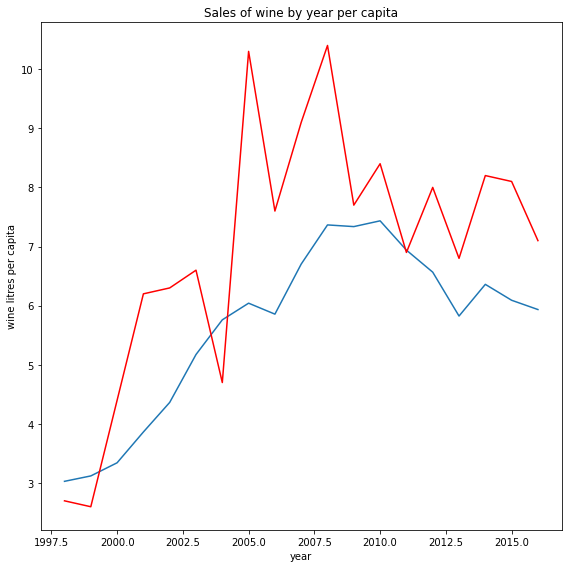

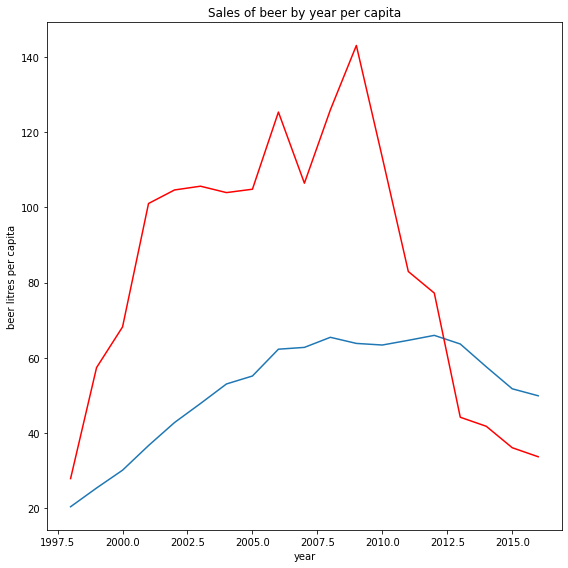

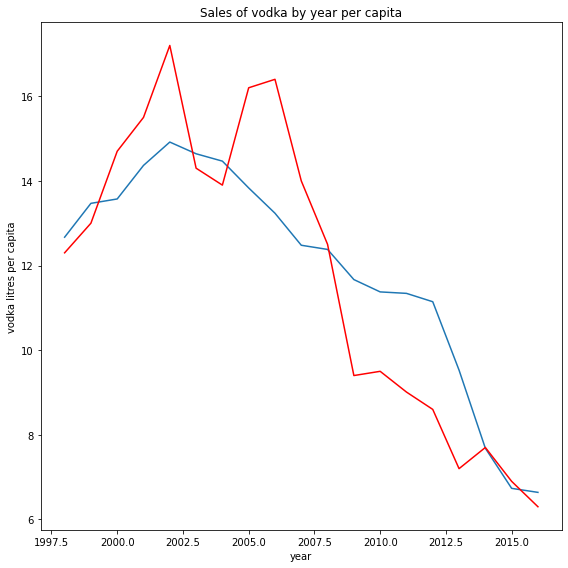

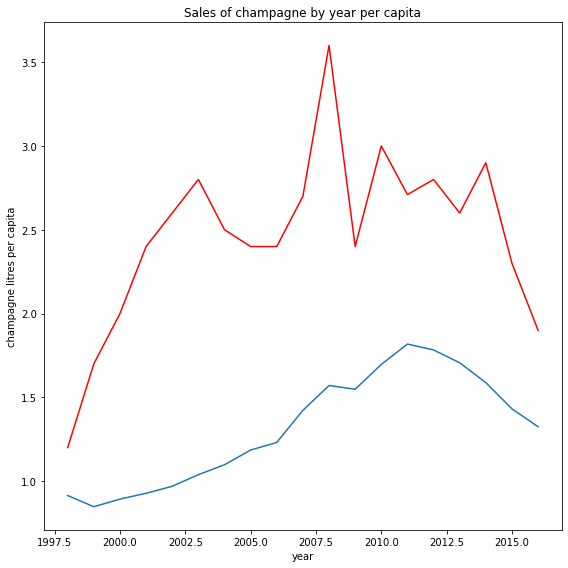

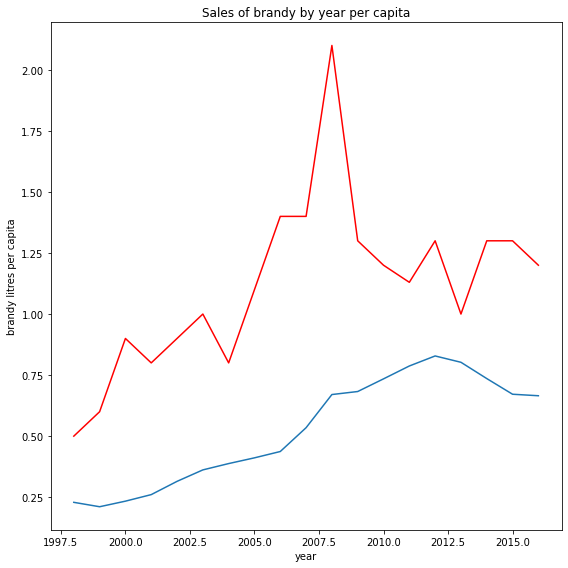

In [52]:
## Plot St. Petersburg vs average sales
for i in drinks:
    plt.figure(figsize=(8, 8))
    plt.plot(dfTotal.index, dfTotal[i], label='Russia')
    plt.plot(dfsp['year'], dfsp[i], color='red', label='St. Petersburg')
    plt.title('Sales of ' + str(i) + ' by year per capita')
    plt.xlabel('year')
    plt.ylabel(str(i) + ' litres per capita')
    plt.tight_layout()
    plt.show()

Next, we need to explore the distribution of sales per capita by region and by each drink. 

We can see that the distribution of data is close to normal, and there are a lot of outliers in each plot. It is essential information for choosing the way of data normalization.

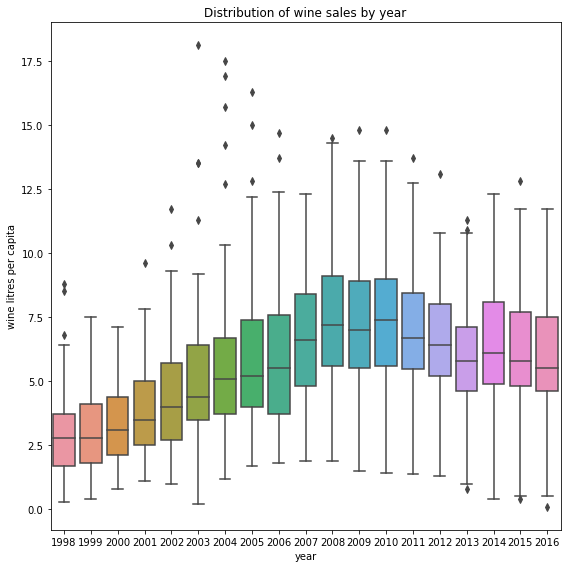

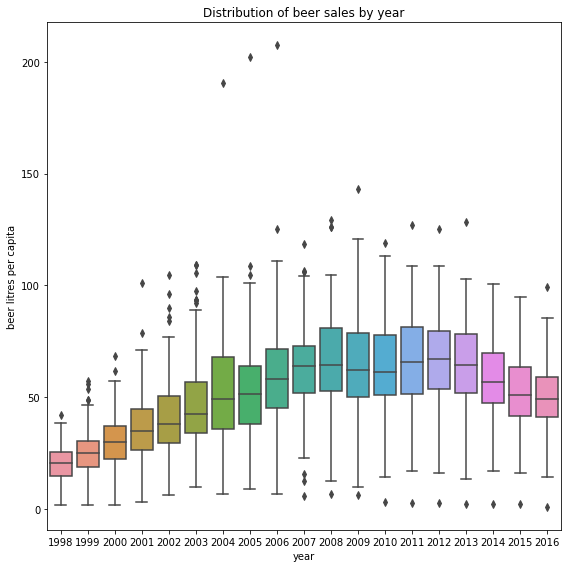

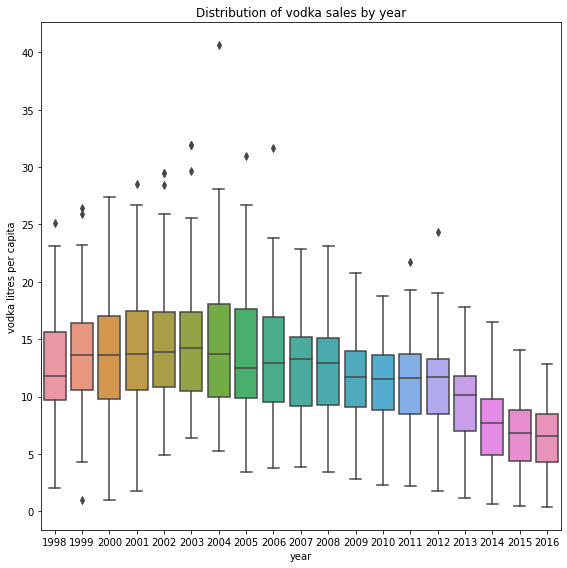

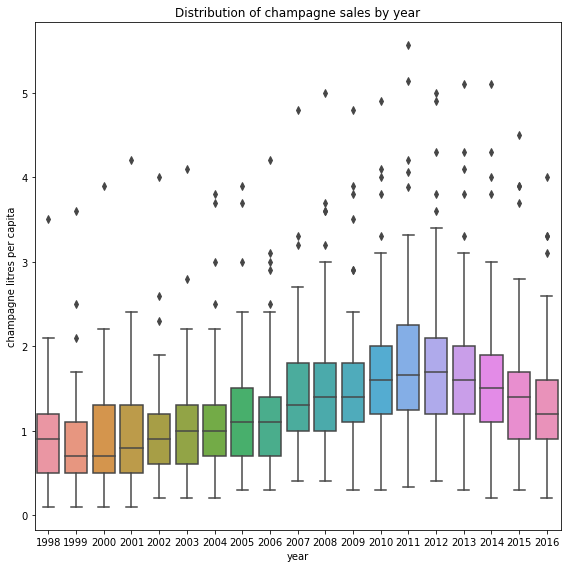

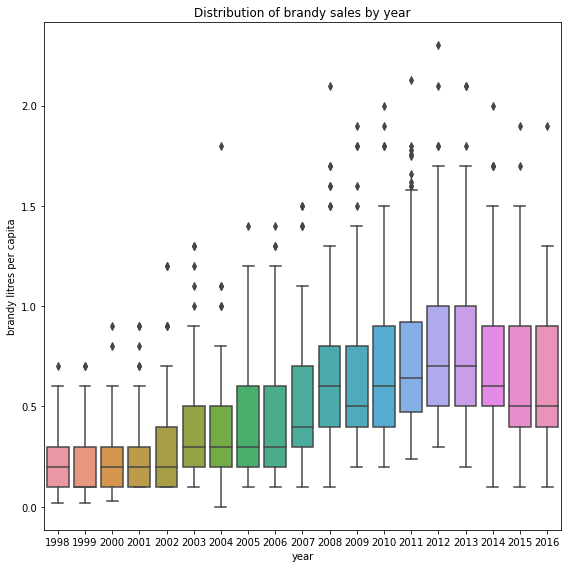

In [53]:
# Plot distribution 
for i in drinks:
    plt.figure(figsize=(8, 8))
    ax = sns.boxplot(data = dfcl, x = 'year', y =i) 
    plt.title('Distribution of ' + str(i) + ' sales by year');
    plt.ylabel(str(i) + ' litres per capita')
    plt.tight_layout()
    plt.show()
    # Show the plot


3. Building recommendation system

For finding regions similar to Saint Petersburg we need to build recommendation engine based on comparition sales per capita by each drink each year. 

In [54]:
#Building Recommendation Engine

dfcl_matrix = dfcl.pivot(index='region', columns='year', values=drinks)
dfcl_matrix

wine                                         \
year                           1998 1999 2000 2001  2002  2003  2004  2005   
region                                                                       
Altai Krai                      3.3  2.2  2.1  2.3   1.6   1.7   2.0   2.0   
Altai Republic                  3.4  4.8  5.4  5.7   5.7   6.4   6.7   6.0   
Amur Oblast                     2.1  2.9  2.4  2.6   2.3   5.3   5.2   5.8   
Arkhangelsk Oblast              4.3  4.6  5.5  7.0   8.1   9.2   7.0   7.6   
Astrakhan Oblast                2.9  3.8  3.7  3.8   4.1   4.5   4.8   4.2   
...                             ...  ...  ...  ...   ...   ...   ...   ...   
Vologda Oblast                  3.9  2.5  3.7  7.8  11.7  18.1  14.2  10.6   
Voronezh Oblast                 1.3  2.1  3.4  3.6   2.8   3.1   3.4   3.5   
Yamalo-Nenets Autonomous Okrug  3.0  4.1  4.6  5.2   5.8   5.0   4.9   4.2   
Yaroslavl Oblast                3.5  3.6  3.5  4.3   4.5   3.8   3.9   5.5   
Zabaykalsky Krai                0.9  1.1  1.9  3.5   4.7   5.9  15.7  16.3   

                                            ... brandy                       \
year                            2006  2007  ...   2007 2008 2009 2010  2011   
region                                      ...                               
Altai Krai                       2.2   2.5  ...    0.2  0.3  0.3  0.4  0.40   
Altai Republic                   4.0   4.8  ...    0.3  0.4  0.4  0.4  0.52   
Amur Oblast                      5.9   5.7  ...    0.3  0.5  0.5  0.6  0.64   
Arkhangelsk Oblast               8.6  10.1  ...    0.8  0.9  1.1  1.2  1.24   
Astrakhan Oblast                 3.9   4.1  ...    0.3  0.4  0.4  0.5  0.56   
...                              ...   ...  ...    ...  ...  ...  ...   ...   
Vologda Oblast                   7.7   9.4  ...    0.4  0.6  0.5  0.4  0.64   
Voronezh Oblast                  3.7   4.7  ...    0.5  0.6  0.6  0.5  0.44   
Yamalo-Nenets Autonomous Okrug   3.0   6.6  ...    1.1  1.1  1.3  1.3  1.78   
Yaroslavl Oblast                 5.7   9.7  ...    0.6  0.7  0.7  0.8  0.85   
Zabaykalsky Krai                13.7   6.7  ...    0.2  0.3  0.4  0.4  0.45   

                                                         
year                           2012 2013 2014 2015 2016  
region                                                   
Altai Krai                      0.4  0.4  0.3  0.3  0.3  
Altai Republic                  0.5  0.4  0.4  0.3  0.3  
Amur Oblast                     0.6  0.7  0.6  0.5  0.5  
Arkhangelsk Oblast              1.1  1.1  1.0  0.9  0.9  
Astrakhan Oblast                0.7  0.6  0.7  0.6  0.6  
...                             ...  ...  ...  ...  ...  
Vologda Oblast                  0.8  0.7  0.6  0.6  0.6  
Voronezh Oblast                 0.6  0.5  0.6  0.5  0.6  
Yamalo-Nenets Autonomous Okrug  1.8  1.7  1.5  1.3  1.3  
Yaroslavl Oblast                1.1  1.0  1.0  0.9  1.0  
Zabaykalsky Krai                0.4  0.4  0.3  0.3  0.3  

[81 rows x 95 columns]

Since each drink has an equal weight for similarity definition, we need to normalize data. Standard scaler should work well, but we know that there are a lot of outliers in the data. So for our data normalizing in a 95% confidence interval gives more precise results.

In [55]:
#Normalization by year, drink
dfcl_matrix_norm = dfcl_matrix
scaler = RobustScaler(quantile_range=(2.5, 97.5))
scaled_values = scaler.fit_transform(dfcl_matrix) 
dfcl_matrix_norm.loc[:,:] = scaled_values

The last step is calculating the cosine similarity between Saint Petersburg and other regions and then getting the list of 10 regions similar to Saint Petersburg the most.

In [56]:
# Generate the similarity matrix

similarities = cosine_similarity(dfcl_matrix_norm)

# Wrap the similarities in a DataFrame
cosine_similarity_df = pd.DataFrame(similarities, index=dfcl_matrix_norm.index, columns=dfcl_matrix_norm.index)

# Find the similarity values for a specific region
cosine_similarity_series = cosine_similarity_df.loc['Saint Petersburg']

# Sort these values highest to lowest
ordered_similarities = cosine_similarity_series.sort_values(ascending=False)


4. Results

In [57]:
# Excluding Saint Petersburg data and printing top 10 similar regions to Saint Petersburg
similar_regions = ordered_similarities.iloc[1:11]
similar_regions

region
Moscow                                   0.779903
Leningrad Oblast                         0.716250
Kaliningrad Oblast                       0.702485
Sverdlovsk Oblast                        0.678184
Krasnoyarsk Krai                         0.673296
Murmansk Oblast                          0.664455
Tyumen Oblast                            0.638774
Khanty–Mansi Autonomous Okrug – Yugra    0.631337
Chelyabinsk Oblast                       0.620150
Republic of Khakassia                    0.604836
Name: Saint Petersburg, dtype: float64

Similarities of top-3 regions in the list are not a surprise: 
- Moscow is the biggest city, and Saint Petersburg is the 2nd biggest;
- Saint Petersburg is located just close to Leningrad Oblast;
- Kaliningrad Oblast has a pretty similar location; both regions are near the Baltic sea

Murmansk Oblast is also located in the European North of Russia and is also located near the sea.  

Other six regions in the list (Sverdlovsk Oblast, Krasnoyarsk Krai, Tyumen Oblast, Khanty–Mansi Autonomous Okrug – Yugra, Chelyabinsk Oblast, Republic of Khakassia) form a large cluster on the map in Siberia. So similarity of them is expectedly logical, but their similarity to Saint Petersburg was not predictable. 

There are entirely no regions from Russian Far East, European Center, and European South in this list. The marketing team needs to build promotion in these regions in utterly different ways if they decide to make it.